# 事前分布の決定

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from scipy import stats

figsize = (10, 5)

In [3]:
filepath = '../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

## 島効果の事前分布

島ごとにグループ化した場合の対数人口の平均値の分布を見ると，平均値は $5.78$ ，標準偏差は $1.98$ である．

以下は島ごとの平均値と正規分布を描画したものであるが，島ごとの違いはこのような正規分布から生成されていると仮定できる．

したがって，島効果を個別に推定するのではなく，適切なハイパーパラメータを設定することで推定精度を向上させることができる．

$\mu_{\text{island}}$ は島効果の平均値に関するハイパーパラメータである．
島効果の期待値は $5.78$ を中心に分布すると仮定する．
その不確実性を考慮し， $\mu_{\text{island}} \sim \text{N}(5.78, 1)$ とする．

$\sigma_{\text{island}}$ は島効果の標準偏差に関するハイパーパラメータである．
島効果の標準偏差は正かつ $1.98$ を中心に分布すると仮定する．
その不確実性を考慮し， $\sigma_{\text{island}} \sim \text{Ga}(\alpha=3, \beta=1)$とする．
このガンマ分布は正であることを保証し， $1.98$ を中心に分布するように設定している．


In [161]:
grouped = df.groupby('island_ids')['log_pop'].agg(['mean', 'std'])

In [164]:
grouped.describe().round(2)

,mean,std
count,82.00,82.00
mean,5.78,0.47
std,1.98,0.22
min,1.85,0.11
25%,4.18,0.29
50%,5.48,0.44
75%,7.19,0.60
max,10.42,1.13


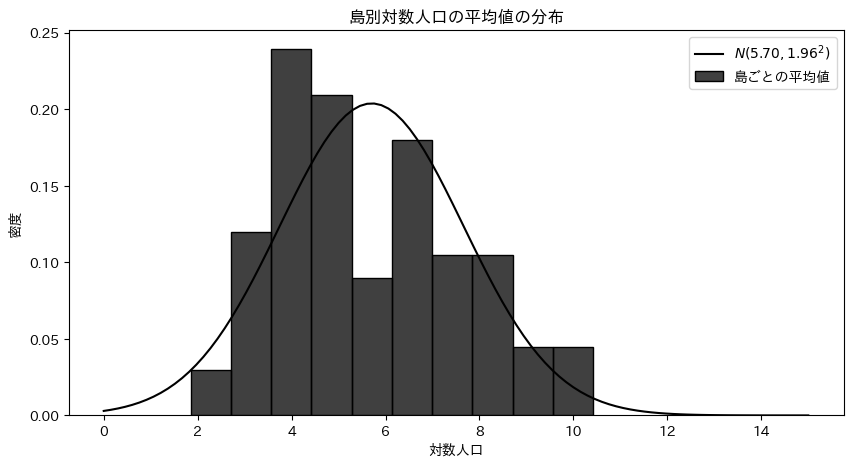

In [7]:
x = np.linspace(0, 15, 100)
mu = df.groupby('island_ids')['log_pop'].mean().mean()
sigma = df.groupby('island_ids')['log_pop'].mean().std()
norm_pdf = stats.norm.pdf(x, mu, sigma)

fig, ax = plt.subplots(figsize=figsize)
sns.histplot(df.groupby('island_ids')['log_pop'].mean(), ax=ax, stat='density', bins=10, color='black', label='島ごとの平均値')
ax.plot(x, norm_pdf, label=f'$N({mu:.2f}, {sigma:.2f}^2)$', color='black')
ax.legend()
ax.set_xlabel('対数人口')
ax.set_ylabel('密度')
ax.set_title('島別対数人口の平均値の分布')

plt.savefig('../../../docs/figures/define_models/mean_by_island.png', bbox_inches='tight')

95%信用区間: (1.62, 8.22)


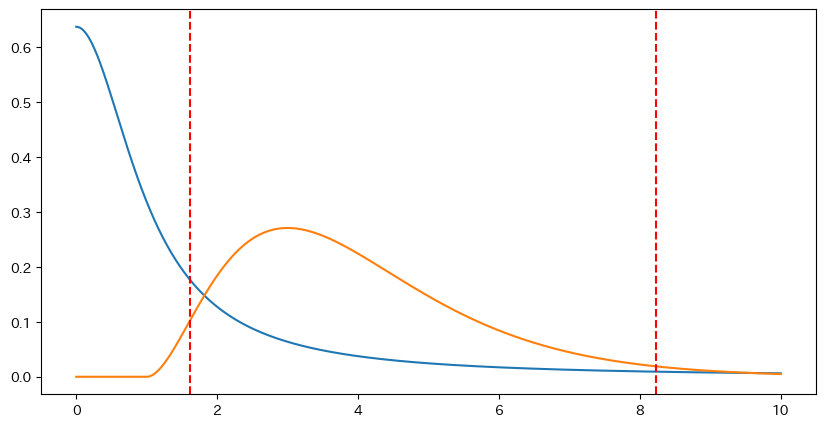

In [26]:
x = np.linspace(0, 10, 1000)
beta = 1
half_cauchy_pdf = stats.halfcauchy.pdf(x, scale=beta)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(x, half_cauchy_pdf)

alpha = 3
beta = 1
gamma_pdf = stats.gamma.pdf(x, alpha, 1/beta)
threshold = 0.05
lwr = stats.gamma.ppf(threshold/2, alpha, 1/beta)
upr = stats.gamma.ppf(1-threshold/2, alpha, 1/beta)
print(f'95%信用区間: ({lwr:.2f}, {upr:.2f})')
ax.plot(x, gamma_pdf)
ax.axvline(lwr, color='red', linestyle='--')
ax.axvline(upr, color='red', linestyle='--')


## 年効果の事前分布

年平均の推移は1980年以降は減少傾向にあり，最初の $1960$ 年を $0$ とすると平均は $-0.977$ , 標準偏差は $0.7$ である．

したがって，年効果を個別に推定するのではなく，適切なハイパーパラメータを設定することで推定精度を向上させることができる．

$\mu_{\text{year}}$ は年効果の平均値に関するハイパーパラメータである．
年効果の期待値は $-0.977$ を中心に分布すると仮定する．その不確実性を考慮し， $\mu_{\text{year}} \sim \text{N}(-0.977, 1)$ とする．

$\sigma_{\text{year}}$ は年効果の標準偏差に関するハイパーパラメータである．
年効果の標準偏差は正かつ $0.7$ を中心に分布すると仮定する．
その不確実性を考慮し， $\sigma_{\text{year}} \sim \text{Ga}(\alpha=2, \beta=1)$とする．


In [8]:
year_mean = df.groupby('year')['log_pop'].mean()
year_mean_adj = year_mean - year_mean.iloc[0]
year_mean_adj.describe().round(3)

count    13.000
mean     -0.968
std       0.588
min      -1.862
25%      -1.369
50%      -1.019
75%      -0.654
max       0.000
Name: log_pop, dtype: float64

In [9]:
year_std = df.groupby('year')['log_pop'].std()
year_std_adj = year_std - year_std.iloc[0]
year_std_adj.describe().round(3)

count    13.000
mean      0.335
std       0.188
min      -0.010
25%       0.285
50%       0.328
75%       0.473
max       0.579
Name: log_pop, dtype: float64

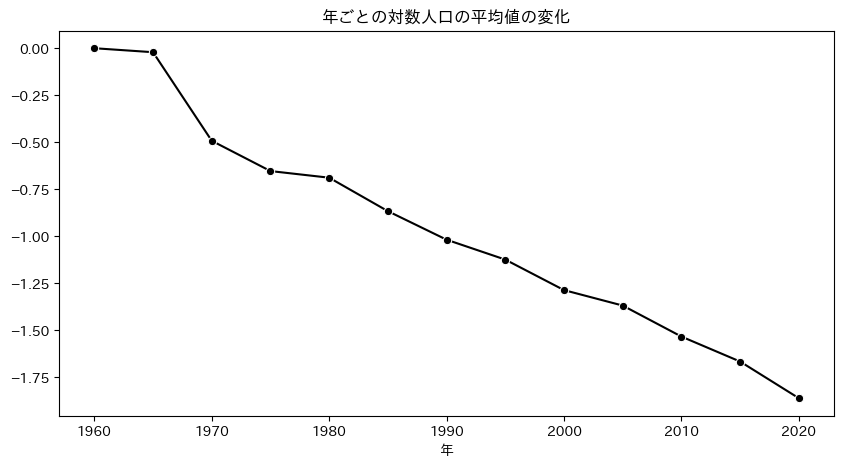

In [15]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x=year_mean_adj.index, y=year_mean_adj.values, ax=ax, color='black', marker='o')

ax.set_xlabel('年')
ax.set_title('年ごとの対数人口の平均値の変化')
plt.savefig('../../../docs/figures/define_models/yearly_mean.png', bbox_inches='tight')

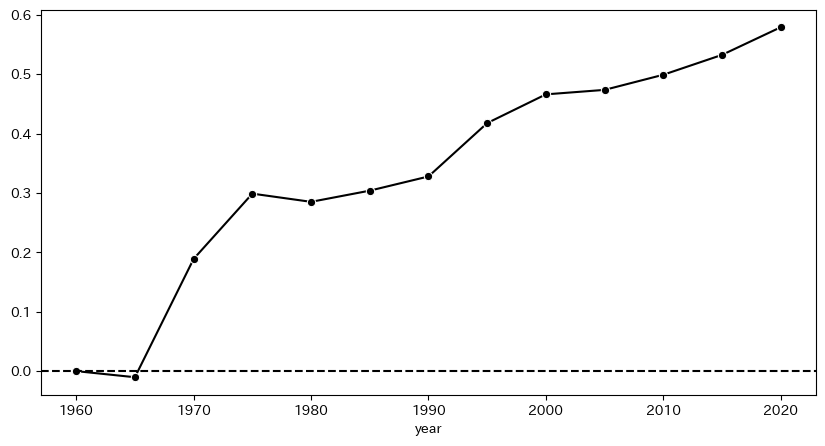

In [10]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x=year_std_adj.index, y=year_std_adj.values, ax=ax, color='black', marker='o')
ax.axhline(0, color='black', linestyle='--')

## $\beta$ の事前分布

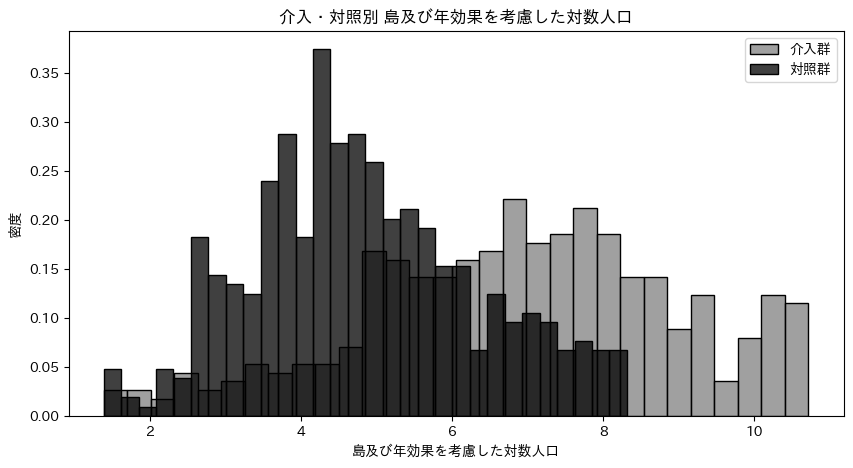

In [5]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
sns.histplot(treatment_df['log_pop'], bins=30, label='介入群', ax=ax, stat='density', color='gray')
sns.histplot(control_df['log_pop'], bins=30, label='対照群', ax=ax, stat='density', color='black')
ax.set_title('介入・対照別 島及び年効果を考慮した対数人口')
ax.set_xlabel('島及び年効果を考慮した対数人口')
ax.set_ylabel('密度')
ax.legend()
plt.show()

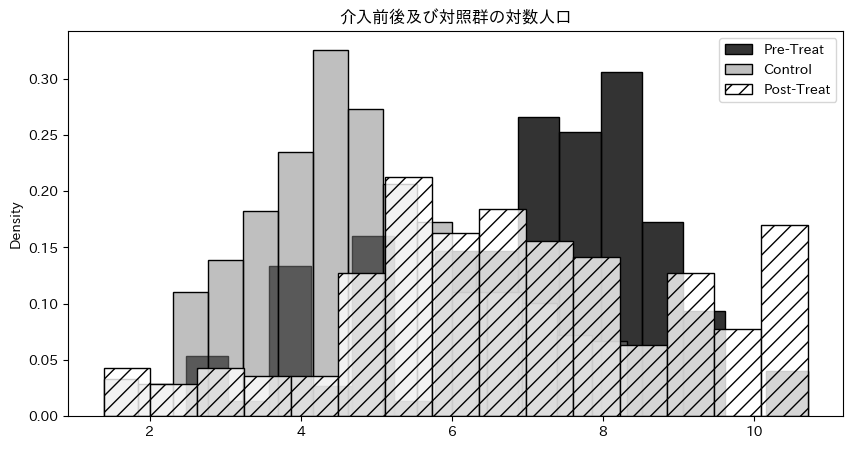

In [8]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
sns.histplot(pre, bins=15, label='Pre-Treat', ax=ax, stat='density', color='black', edgecolor='black', alpha=0.8)
sns.histplot(control, bins=15, label='Control', ax=ax, stat='density', color='gray', edgecolor='black', alpha=0.5)
sns.histplot(post, bins=15, label='Post-Treat', ax=ax, stat='density', color='white', edgecolor='black', alpha=0.8, hatch='//')
ax.set_title('介入前後及び対照群の対数人口')
ax.set_xlabel('')
ax.legend()

島効果及び年効果を考慮した対数人口の基本統計量を確認する．
Pre-Treatが介入前の介入群，Controlが対照群，Post-Treatが介入後の介入群である．


|            | count  |   mean   |   sd    |   min    |   50%    |   max   |
| :--------: | :----: | :------: | :-----: | :------: | :------: | :-----: |
| Pre-Treat  | $178$  | $-0.135$ | $0.330$ | $-1.472$ | $-0.092$ | $1.199$ |
| Post-Treat | $486$  | $-0.022$ | $0.209$ | $-1.256$ | $0.003$  | $0.655$ |
|  Control   | $1059$ | $0.033$  | $0.230$ | $-0.937$ | $0.021$  | $1.328$ |

平均，最小，中央，最大によれば，介入群は対照群よりも小さく，介入の前後で比較すると最大値を除いてPre-Treatの方が小さい．

標準偏差に関しては，Pre-Treatが最も大きく，Post-Treatが最も小さい．

Pre-TreatとPost-Treatの平均値の差は $0.113 (= -0.022 - -0.135)$ であり，これらは対数値であるから，だいたい $11\%$ の正の影響があると推測できる．

したがって，介入群は対照群よりも人口が少ない傾向にあるが，架橋は数%の人口増加と安定化をもたらす可能性がある．

In [10]:
describe_list = []
describe_list.append(treatment_df['log_pop'].describe())
describe_list.append(pre.describe())
describe_list.append(post.describe())
describe_list.append(control.describe())
describe_list.append(pre_and_control.describe())
describe_df = pd.DataFrame(describe_list)
describe_df.index = ['treatment', 'pre', 'post', 'control', 'pre_and_control']

In [12]:
describe_df.round(3)

,count,mean,std,min,25%,50%,75%,max
treatment,364.0,6.905,2.069,1.386,5.520,7.013,8.321,10.716
pre,137.0,6.963,1.767,2.485,6.023,7.226,8.219,10.710
post,227.0,6.869,2.234,1.386,5.387,6.736,8.647,10.716
control,452.0,4.819,1.489,1.386,3.761,4.659,5.762,8.313
pre_and_control,589.0,5.318,1.802,1.386,3.970,4.984,6.730,10.710


以上の情報を用いて介入効果を示すパラメータの事前分布 $\beta$ を次のように設定する．

$$\beta \sim \mathcal{N}(0, 0.1^2)$$

期待値は $0$ とする．まずはパラメータの正負に関心があるため，どちらかに偏った情報を持たせないようにする．

標準偏差は $0.1$ とする．標準偏差が $0.1$ の場合， $95\%$ で $-0.196$ から $0.196$ の間に収まる．

指数に変換すると，架橋が人口に与える影響は $-17.80\%$ から $21.65\%$ の間に収まる事になる．

介入前と介入後の平均値の差が $0.113$ であったことを考慮すれば，この事前分布は十分に広い範囲をカバーしているといえる．

また， $\beta \sim \text{Uniform}(-0.2, 0.2)$ といった一様分布ではなく正規分布を選んだ理由は以下のグラフを参考にしてほしい．

$\beta$ が $0.2$ と大きな値を取る確率と $0$ に近い値を取る確率は等価ではなく，大きな値を取る確率が小さいことを反映させるためである．

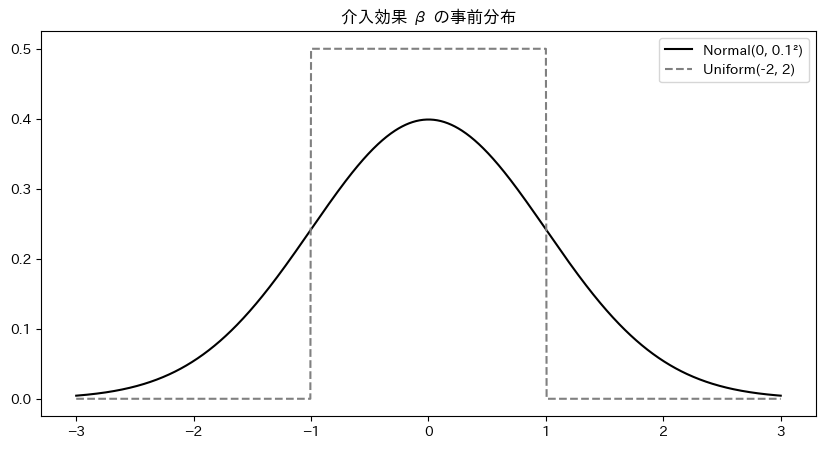

In [31]:
x = np.linspace(-3, 3, 1000)
# normal
mu = 0
sigma = 1
normal_pdf = stats.norm.pdf(x, loc=mu, scale=sigma)
# uniform
low = -1
high = 1
uniform_pdf = stats.uniform.pdf(x, loc=low, scale=high - low)

fig, ax = plt.subplots(figsize=figsize)
ax.plot(x, normal_pdf, label='Normal(0, 0.1²)', color='black')
ax.plot(x, uniform_pdf, label='Uniform(-2, 2)', color='gray', linestyle='--')
ax.legend()
ax.set_title('介入効果 β の事前分布')
plt.show()

In [84]:
effect = 0.196
log_effect = np.log(effect + 1)

print(f'もし効果が {effect:.2%} の場合')
print(f'βは {log_effect:.3f}')

もし効果が 19.60% の場合
βは 0.179


In [116]:
log_effect = 0.196
effect = np.exp(log_effect) - 1

print(f'もしβが {log_effect:.2f} の場合')
print(f'効果は {effect:.2%}')
print(f'つまり，人口は {effect+1:.2f} 倍になる．')

もしβが 0.20 の場合
効果は 21.65%
つまり，人口は 1.22 倍になる．


## 誤差分散の事前分布

誤差分散の事前分布を決定する．

被説明変数は島・時間効果を考慮した対数人口であり，その分散は $0.24^2$ である．

しかしながら，不均一分散を考慮する必要がある．

被説明変数の島別の標準偏差の基本統計量とヒストグラムは以下の通りだ．


| 平均 | 標準偏差 | 最小 | 中央 | 最大 |
| :---: | :---: | :---: | :---: | :---: |
| $0.19$| $0.15$ | $0.02$ | $0.15$ | $0.79$ |


島ごとの標準偏差は0から0.2の間に集中しているが，0.3以上の値を取る島もいくつか存在する．

したがって，島ごとに誤差分散が異なるように事前分布を設定する必要がある．

$$
\begin{aligned}
\sigma_i &\sim \text{C}^+(\sigma_{\text{global}}^2) \\
\end{aligned}
$$

ここで，$\text{C}^+$ は半コーシー分布を表し，$\sigma_{\text{global}}$ はハイパーパラメータである．

$\sigma_{global}^2$ は島間を横断した誤差分散の期待値であり，島内の誤差分散 $\sigma_i^2$ はこの期待値を中心に分布する．

$\sigma_{global} \sim \text{C}^+(0.15^2)$ と設定する．

このハイパーパラメータは，被説明変数の島別標準偏差の標準偏差が $0.15^2$ であることを考慮して設定した．

なお，コーシー分布は裾野の重い確率分布であり，正規分布に比べて情報が弱い事前分布である．したがって過適合のリスクを緩和する狙いもある．

以下のグラフを参考されたい．

In [202]:
y_std_i = df.groupby('island_ids')['log_pop_star'].std()
y_std_i.describe()

count    94.000000
mean      0.191469
std       0.146893
min       0.020647
25%       0.090140
50%       0.151969
75%       0.235365
max       0.792815
Name: log_pop_star, dtype: float64

In [206]:
count_above_02 = (y_std_i >= 0.2).sum()
print(f'0.3以上の個数: {count_above_02}')

0.3以上の個数: 31


Text(0.5, 1.0, '島別の標準偏差')

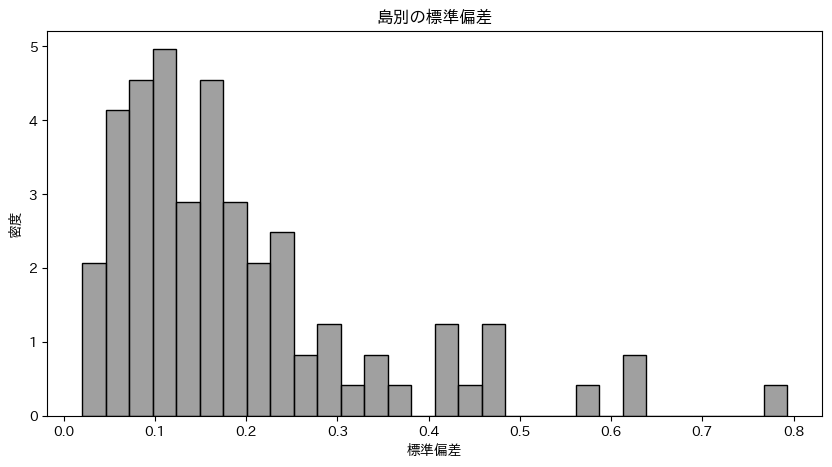

In [244]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
sns.histplot(y_std_i, bins=30, ax=ax, color='gray', stat='density')
ax.set_xlabel('標準偏差')
ax.set_ylabel('密度')
ax.set_title('島別の標準偏差')

In [204]:
# パラメータ
sigma = 0.1
value = 0.25

# 半正規分布の累積分布関数を使用して確率を計算
probability = stats.halfnorm.cdf(value, scale=sigma)

print(f"半正規分布 N(0, {sigma}) が {value} 以下の値を取る確率: {probability:.4f}")

半正規分布 N(0, 0.1) が 0.25 以下の値を取る確率: 0.9876


<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2954/3146203848.py:21: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title('誤差分散のハイパーパラメータ $\sigma_{\\text{global}}$')


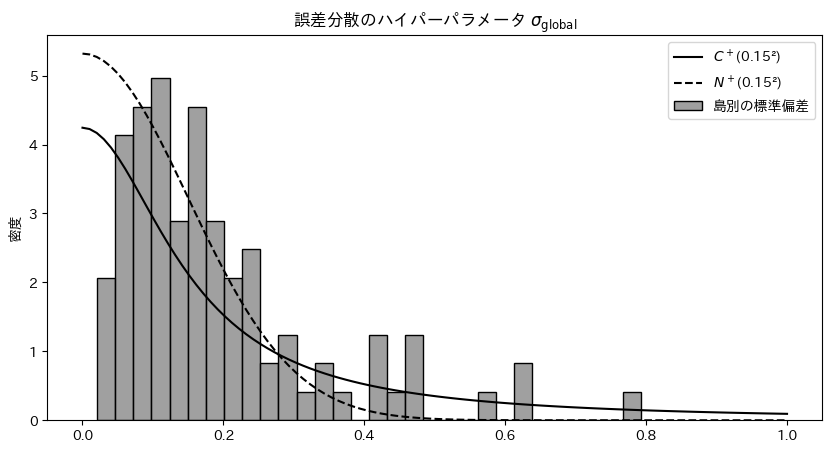

In [243]:
x = np.linspace(0, 1, 100)

sigma = 0.15

# half-normal
half_normal_pdf = stats.halfnorm.pdf(x, scale=sigma)

# half-cauchy
half_cauchy_pdf = stats.halfcauchy.pdf(x, scale=sigma)

# inverse-gamma
alpha = 2.25
beta = 0.2
inverse_gamma_pdf = stats.invgamma.pdf(x, a=alpha, scale=beta)

fig, ax = plt.subplots(figsize=figsize)
sns.histplot(y_std_i, bins=30, ax=ax, color='gray', stat='density', label='島別の標準偏差')
ax.plot(x, half_cauchy_pdf, label=f'$C^+$({sigma}²)', color='black', linestyle='-')
ax.plot(x, half_normal_pdf, label=f'$N^+$({sigma}²)', color='black', linestyle='--')
# ax.plot(x, inverse_gamma_pdf, label=f'InverseGamma({alpha, beta})', color='black', linestyle='-.')
ax.set_title('誤差分散のハイパーパラメータ $\sigma_{\\text{global}}$')
ax.set_ylabel('密度')
ax.set_xlabel('')
ax.legend()
plt.show()

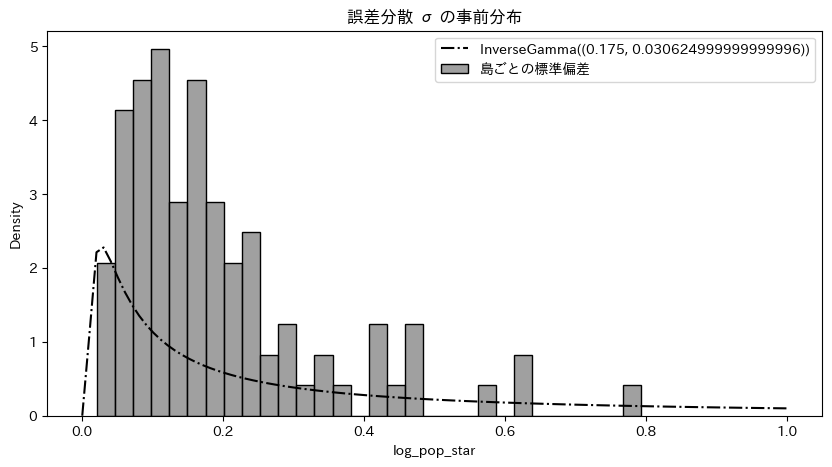

In [242]:
x = np.linspace(0, 1, 100)

sigma = 0.3

# half-normal
half_normal_pdf = stats.halfnorm.pdf(x, scale=sigma)

# half-cauchy
half_cauchy_pdf = stats.halfcauchy.pdf(x, scale=sigma)

# inverse-gamma
sigma_grobal = 0.175
k = 1
alpha = k * sigma_grobal
beta = k * sigma_grobal ** 2
inverse_gamma_pdf = stats.invgamma.pdf(x, a=alpha, scale=beta)

fig, ax = plt.subplots(figsize=figsize)
sns.histplot(y_std_i, bins=30, ax=ax, color='gray', stat='density', label='島ごとの標準偏差')
# ax.plot(x, half_normal_pdf, label=f'Half-Normal({sigma})', color='black', linestyle='-')
# ax.plot(x, half_cauchy_pdf, label=f'Half-Cauchy({sigma})', color='black', linestyle='--')
ax.plot(x, inverse_gamma_pdf, label=f'InverseGamma({alpha, beta})', color='black', linestyle='-.')
ax.set_title('誤差分散 σ の事前分布')
ax.legend()
plt.show()

## Dynamic TWFE $\beta_l$

$$
\begin{aligned}
\beta_l &\sim N(\mu_{\beta}, \sigma_{\beta}^2) \\
\mu_{\beta} &\sim N(0, 0.1^2) \\
\sigma_{\beta} &\sim C^+(0.1^2) \\
\end{aligned}
$$

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2954/3944009318.py:10: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_title('$β_l$ の期待値のハイパーパラメータ $\mu_{\\beta}$')


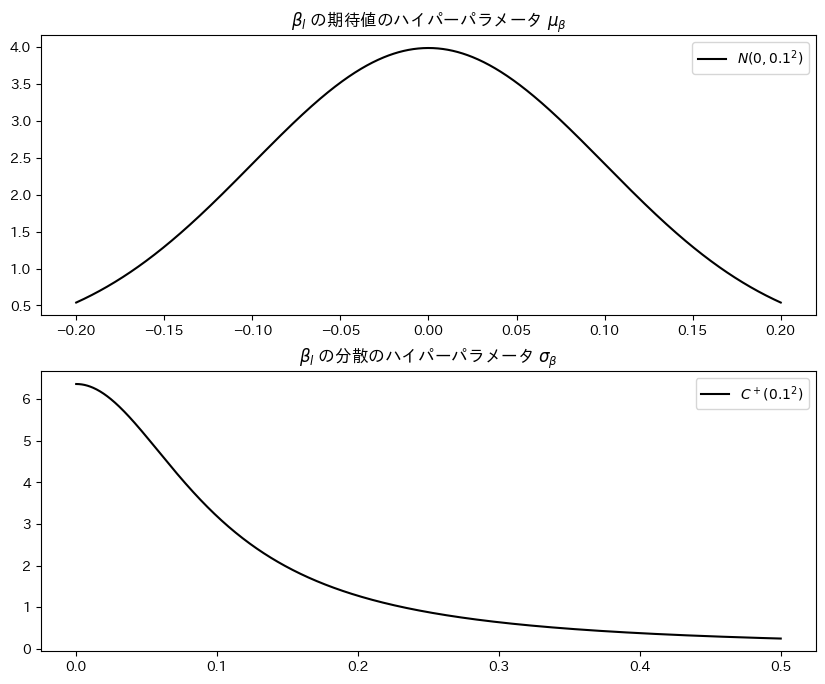

In [314]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# mu
x = np.linspace(-0.2, 0.2, 1000)
mu = 0
sigma = 0.1
mu_beta_pdf = stats.norm.pdf(x, loc=mu, scale=sigma)

ax[0].plot(x, mu_beta_pdf, color='black', label='$N(0, 0.1^2)$')
ax[0].set_title('$β_l$ の期待値のハイパーパラメータ $\mu_{\\beta}$')

# sigma
x = np.linspace(0, 0.5, 1000)
sigma = 0.1
sigma_beta_pdf = stats.halfcauchy.pdf(x, scale=sigma)

ax[1].plot(x, sigma_beta_pdf, color='black', label='$C^+(0.1^2)$')
ax[1].set_title('$β_l$ の分散のハイパーパラメータ $σ_β$')
ax[0].legend()
ax[1].legend()

plt.show()

## 尤度

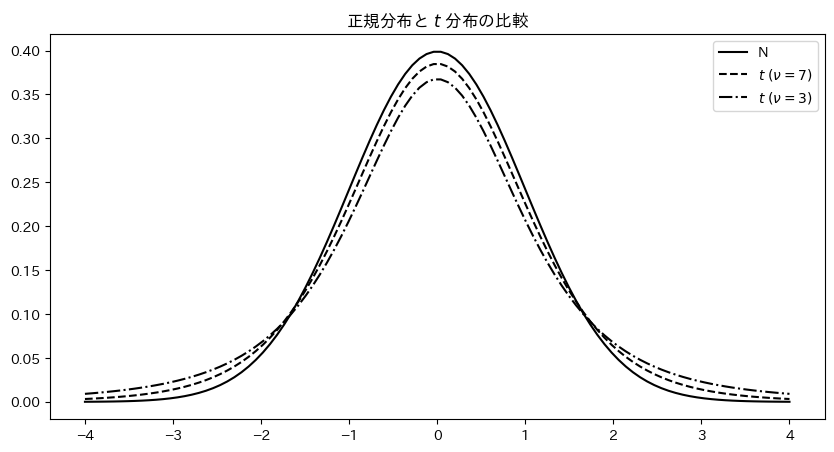

In [51]:
x = np.linspace(-4, 4, 100)

mu = 0
sigma = 1
nu_3 = 3
nu_7 = 7

# 各分布の確率密度関数
normal_pdf = stats.norm.pdf(x, loc=mu, scale=sigma)
t_3_pdf = stats.t.pdf(x, df=nu_3, loc=mu, scale=sigma)
t_7_pdf = stats.t.pdf(x, df=nu_7, loc=mu, scale=sigma)

fig, ax = plt.subplots(figsize=figsize)
ax.plot(x, normal_pdf, label='N', color='black', linestyle='-')
ax.plot(x, t_7_pdf, label=f'$t$ $(ν = {nu_7})$', color='black', linestyle='--')
ax.plot(x, t_3_pdf, label=f'$t$ $(ν = {nu_3})$', color='black', linestyle='-.')
# sns.histplot(df['log_pop_star'], bins=30, ax=ax, color='gray', stat='density')
ax.legend()
ax.set_title('正規分布と $t$ 分布の比較')
plt.show()

### $\nu$

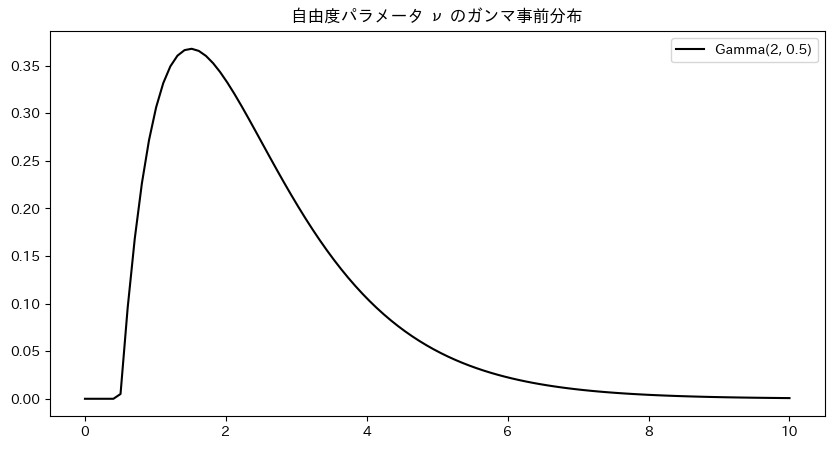

In [240]:
x = np.linspace(0, 10, 100)
alpha = 2
beta = 0.5

gamma_pdf = stats.gamma.pdf(x, alpha, beta)

fig, ax = plt.subplots(figsize=figsize)
ax.plot(x, gamma_pdf, color='black', label='Gamma(2, 0.5)')
ax.set_title('自由度パラメータ ν のガンマ事前分布')
ax.legend()
plt.show()